In [1]:
# !uv sync --all-extras

In [2]:
%load_ext autoreload
%autoreload 2

import cryogrid_pytools as cg
from cryogrid_pytools import data

In [3]:
bbox = (71.0, 36.5, 72.0, 37.5)
res_m = 100
res_deg = res_m / 111_111

dem = cg.data.get_dem_copernicus(bbox_WSEN=bbox, res=res_deg, epsg=4326, collection="cop-dem-glo-90")

2025-07-17 15:21:21 | INFO     - Fetching COP DEM Global data from Planetary Computer (cop-dem-glo-90 @ 0.0009)


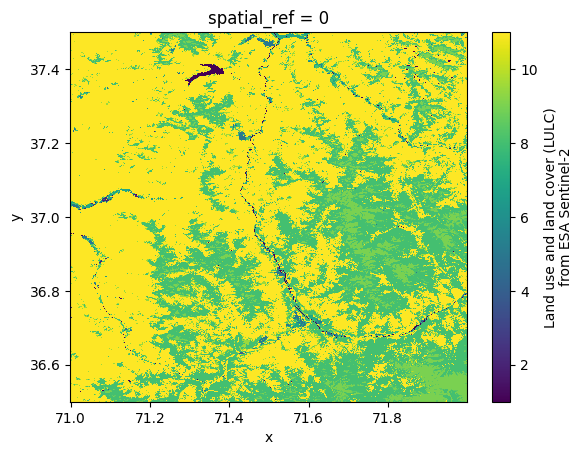

In [5]:
cg.data.get_esri_land_cover(bbox, res=res_deg, epsg=4326).plot()

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

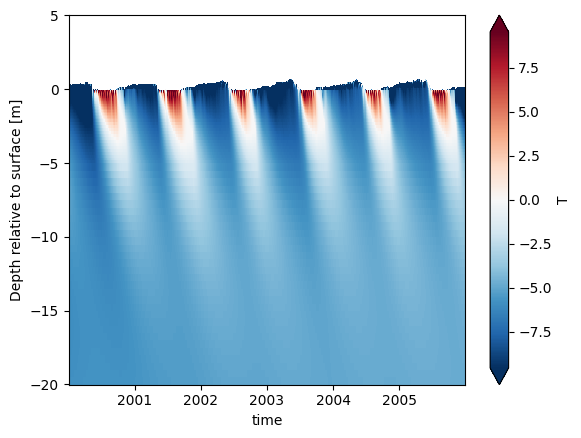

In [8]:
fname = '/Users/luke/Work/PAMIR/pamir-clusters/runs/batch0n6/output/batch0n6_110001_20051231.mat'

ds_profile = cg.read_OUT_regridded_file(
    fname, 
    deepest_point=-20,  # not required for a single file - will not return depth if not given
)  
# output dims are [time, level]

# since deepest_point is provided above, we can set depth as a dim instead of level
ds_profile = ds_profile.swap_dims(level='depth')  # the same can be done for elevation
ds_profile.T.plot(robust=True)


In [11]:
fname_profiles = '/Users/luke/Work/PAMIR/pamir-clusters/runs/batch0n6/output/batch0n6_110058_2???1231.mat'

# when reading multiple files, deepest_point is required since multiple 
out = cg.read_OUT_regridded_files(fname_profiles, deepest_point=-20)
out

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


2025-07-02 10:14:47 | INFO     - Depths are the same for all gridcells. Setting depth as the dimension.


[Parallel(n_jobs=-1)]: Done 2 out of 5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed:    0.4s finished


<xarray.Dataset> Size: 293MB
Dimensions:       (index: 1, depth: 501, time: 36528)
Coordinates:
  * index         (index) int64 8B 110058
  * time          (time) datetime64[ns] 292kB 2000-01-01T06:00:00 ... 2024-12-31
  * depth         (depth) float64 4kB 5.0 4.95 4.9 4.85 ... -19.9 -19.95 -20.0
Data variables:
    T             (index, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    water         (index, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    ice           (index, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    class_number  (index, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    elevation     (depth) float32 2kB dask.array<chunksize=(501,), meta=np.ndarray>

In [13]:
da = out.T[0].assign_attrs(long_name='Temperature', units='°C').compute()

In [24]:
ds = cg.analyze_profile(da)

Text(0.5, 1.0, '')

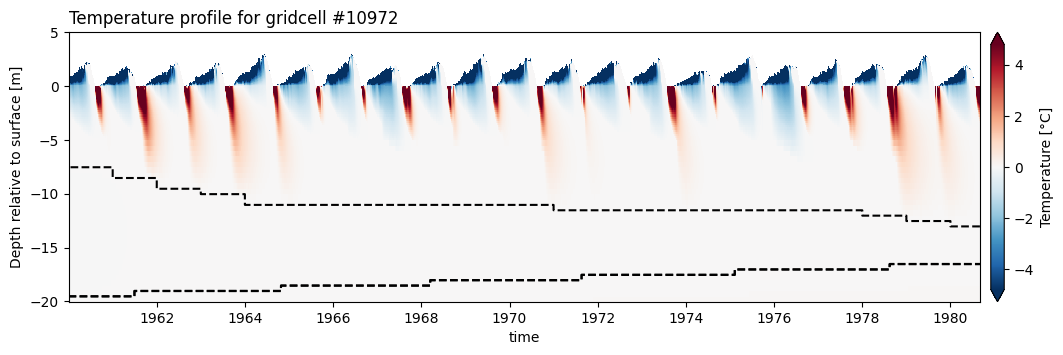

In [5]:
img = viz.plot_profile(ds.ground_temperature)
ds.ground_thermal_state.plot.contour(levels=[0.5, 1.5, 2.5], colors='k', ax=img.axes, linestyles='--')
img.axes.set_title('')

# Reading struct files from MATLAB


Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:

<div style="background-color: #def0da; color: #64946D; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">ⓘ Tip for spatial data </div>
 <div style="font-size: 12px">
 To get spatial data from MATLAB, you need to save the data as shown in the code block below. The rest of the example in this code relies on this. 
 </div>
</div>

```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [5]:
import cryogrid_pytools.viz as viz
import rioxarray as rxr

fname_spatial = "/Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/archive/abramov-small-3classes/outputs/run_spatial_info.mat"
fname_dem =     "/Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/archive/abramov-small-3classes/forcing/elevation.tif"

# read in the spatial data 
ds_spatial = cg.read_mat_struct_as_dataset(
    fname_spatial, 
    index=['coord_y', 'coord_x'],  # set the index to the spatial coordinates - this maps the data to 2D
    drop_keys=['cluster_idx'],  # the cluster_idx is not the same size as the other data, so we drop it, but its added as a coordinate
)

# we have to assign a CRS to the spatial data. The DEM is used as a reference
crs = rxr.open_rasterio(fname_dem).rio.crs
# now we can write the CRS to the spatial data (this is important for plotting later on)
ds_spatial = (
    ds_spatial
    .rename(coord_y='y', coord_x='x')  # rioxarray expects the coordinates to be named x and y
    .rio.write_crs(crs)  # and set the CRS
)

In [7]:
ds_flat = cg.read_mat_struct_as_dataset(
    fname_spatial,  # when leaving out the index, the data is kept in its flat shape
    drop_keys=['cluster_idx'])  
# the mask removes all points that are not a cluster centroid
cluster_centroids = ds_flat.index.isin(ds_flat.cluster_idx)

gdf_locations = viz.gridpoints_to_geodataframe(ds_flat.sel(index=cluster_centroids))

### Plotting data on interactive map

We can use `folium` to plot the data on an interactive map.

In the `viz` module, there are some functions to help with this. The `plot_map` function automatically plots the data to a `folium` map. 

In [8]:
m = viz.plot_folium_map(ds_spatial.stratigraphy_index)
# m = viz.plot_folium_map(ds_spatial.elevation, m=m)
m = gdf_locations.explore(m=m, name='Sample locations', **viz.MARKER_STYLES.blue_circle)
m = viz.finalize_folium_map(m)
m

/Users/luke/Git/CryoGrid-pyTools/.venv/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


# Mapping profile metrics to spatial maps

In [27]:
import cryogrid_pytools.viz as viz
import rioxarray as rxr

In [29]:
# all data using regex pattern - [0-9]+ is the run number, 197[5-9] is 1975-1979, [0-9]{4} is the mmdd part of the date
fname_profiles = '/Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test0/output/profiles_mat/abramov-test0_[0-9]+_197[8-9][0-9]{4}.mat' 
fname_spatial  = "/Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test0/run_spatial_info.mat"

ds_profiles = cg.read_OUT_regridded_files(fname_profiles, deepest_point=-20)
# the outputs of ds_profiles have dimensions [gridcell, depth, time]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 242 out of 242 | elapsed:    2.5s finished


2025-04-17 12:23:29 | INFO     - Depths are the same for all gridcells. Setting depth as the dimension.


In [31]:
ds_profiles

<xarray.Dataset> Size: 3GB
Dimensions:       (index: 121, depth: 501, time: 2922)
Coordinates:
  * index         (index) int64 968B 167 297 364 451 511 ... 7923 7962 8079 8159
  * time          (time) datetime64[ns] 23kB 1977-09-01 ... 1979-09-01
  * depth         (depth) float64 4kB 5.0 4.95 4.9 4.85 ... -19.9 -19.95 -20.0
Data variables:
    T             (index, depth, time) float32 709MB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    water         (index, depth, time) float32 709MB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    ice           (index, depth, time) float32 709MB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    class_number  (index, depth, time) float32 709MB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    elevation     (index, depth) float32 242kB dask.array<chunksize=(1, 501), meta=np.ndarray>

In [35]:
# we can now calculate the mean temperature profile for the 1970s for each gridcell [gridcell, depth]
temp_profile_mean = ds_profiles['T'].mean('time', keep_attrs=True)  # calculate the mean over time, keeping the attributes

temp_2m_mean = (
    temp_profile_mean
    .sel(depth=-2, method='nearest')  # select the temperature at 2m depth (or the nearest depth)
    .drop_vars(['depth', 'elevation'])  # drop the depth and elevation coordinates
    .assign_attrs(long_name='2 m ground temperature', units='°C')  # assign attributes to the data (for plotting)
    .compute())  # load the data into memory

In [36]:
# note that the coordinate reference system (CRS) is required to import this data correctly
ds_spatial = cg.spatial_clusters.read_spatial_data(fname_spatial)

Text(0.0, 1.0, 'CryoGrid mean temperature 1975-1979 for Abramov region')

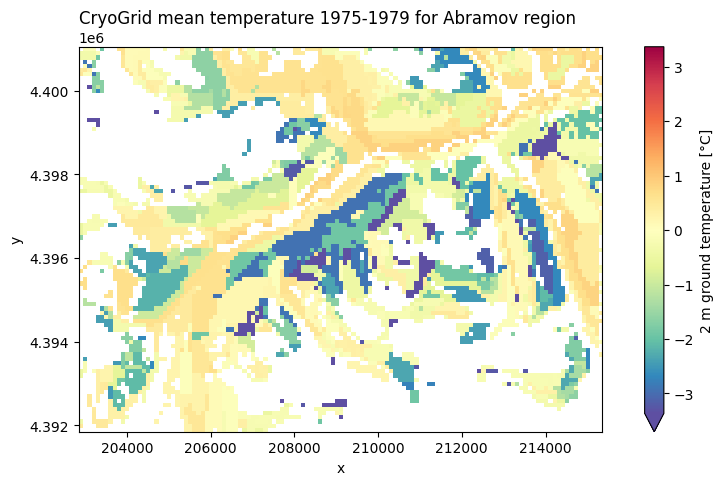

In [37]:
temp_2m_mapped = cg.spatial_clusters.map_gridcells_to_clusters(
    temp_2m_mean, 
    ds_spatial.cluster_centroid_index_mapped)

img = temp_2m_mapped.plot.imshow(robust=True, aspect=2.2, size=5, cmap='Spectral_r')
img.axes.set_aspect('equal')
img.axes.set_title('', loc='center')
img.axes.set_title('CryoGrid mean temperature 1975-1979 for Abramov region', loc='left')

# img.figure.savefig('./docs/imgs/mapped_temp_2m-1975_1979.png', dpi=150, bbox_inches='tight')

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [14]:
fname_excel = '/Users/luke/Work/PAMIR//CryoGrid-run-manager/runs/abramov-small-3classes/abramov-small-3classes.xlsx'
config = cg.CryoGridConfigExcel(fname_excel, check_file_paths=True, check_strat_layers=True)

2025-04-08 11:03:08 | INFO     - Found root path: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-small-3classes
2025-04-08 11:03:09 | SUCCESS  - Loaded CryoGrid Excel configuration file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-small-3classes/abramov-small-3classes.xlsx
2025-04-08 11:03:09 | INFO     - Checking file locations...
2025-04-08 11:03:09 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-small-3classes/forcing/elevation.tif
2025-04-08 11:03:09 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-small-3classes/forcing/surface_classes.tif
2025-04-08 11:03:09 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-small-3classes/forcing/era5.mat
2025-04-08 11:03:09 | INFO     - Checking stratigraphy layers...
2025-04-08 11:03:09 | SUCCESS  - [STRAT_layers_1]  parameters passed checks
2025-04-08 11:03:09 | SUCCESS  - [STRAT_layers_2]  parameters passed checks
20

In [27]:
deepest_point = -config.get_output_max_depth(output_class='OUT_regridded_FCI2')  # this can be used to find the maximum depth of the output
cg.read_OUT_regridded_files(fname_profiles, deepest_point=deepest_point)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   10.3s finished


2025-04-08 11:05:39 | INFO     - Depths are the same for all gridcells. Setting depth as the dimension.


<xarray.Dataset> Size: 11GB
Dimensions:       (gridcell: 150, depth: 501, time: 7309)
Coordinates:
  * gridcell      (gridcell) int64 1kB 3165 4032 4181 4318 ... 94096 95287 95517
  * time          (time) datetime64[ns] 58kB 1974-09-01 ... 1979-09-01
    elevation     (gridcell, depth) float64 601kB dask.array<chunksize=(1, 501), meta=np.ndarray>
  * depth         (depth) float64 4kB 5.0 4.95 4.9 4.85 ... -19.9 -19.95 -20.0
Data variables:
    T             (gridcell, depth, time) float32 2GB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    water         (gridcell, depth, time) float32 2GB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    ice           (gridcell, depth, time) float32 2GB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    class_number  (gridcell, depth, time) float32 2GB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>
    FCI           (gridcell, depth, time) float32 2GB dask.array<chunksize=(1, 501, 1461), meta=np.ndarray>

# Reading ERA5 forcing data

<div style="background-color: #fcf8e5; color: #8C6D46; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">⚠ Warning</div>
 <div style="font-size: 12px">
 This is currently still in development. 
 </div>
</div>

In [13]:
fname = '/Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/forcing/era5.mat'
ds = cg.forcing.read_mat_ear5(fname)
ds

<xarray.Dataset> Size: 285MB
Dimensions:  (lon: 2, lat: 2, level: 8, time: 177273)
Coordinates:
  * lon      (lon) float32 8B 71.5 71.75
  * lat      (lat) float32 8B 40.0 39.75
  * level    (level) int64 64B 300 500 600 700 800 850 900 1000
  * time     (time) datetime64[ns] 1MB 1960-01-01 ... 2020-09-01
Data variables: (12/21)
    Zs       (time, lat, lon) float64 6MB 2.145e+03 2.274e+03 ... 3.679e+03
    u10      (time, lat, lon) float64 6MB -0.4 -0.13 -0.67 ... 0.02 -0.22 0.32
    v10      (time, lat, lon) float64 6MB 3.45 3.51 1.89 1.69 ... 0.63 0.86 0.61
    ps       (time, lat, lon) float64 6MB 7.91e+04 7.79e+04 ... 6.54e+04
    Td2      (time, lat, lon) float64 6MB -29.95 -30.95 -35.92 ... 0.46 0.46
    T2       (time, lat, lon) float64 6MB -11.62 -15.53 -15.41 ... 2.34 1.99
    ...       ...
    wind_sf  float64 8B 0.01
    q_sf     float64 8B 1e-06
    ps_sf    float64 8B 100.0
    rad_sf   float64 8B 0.1
    T_sf     float64 8B 0.01
    P_sf     float64 8B 0.01
Attributes:
    info:     Data read in from CryoGrid ERA5 forcing file. Data has been sca...
    source:   /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/for...

In [14]:
fname = '/Users/luke/Work/PAMIR/archive/cryogrid-ITCH-ML/data/Tronfjell_summit.mat'
forcing = cg.read_mat_struct_as_dataset(fname, index='timeForcing', index_is_datenum=True)
forcing

<xarray.Dataset> Size: 28MB
Dimensions:       (timeForcing: 236688)
Coordinates:
  * timeForcing   (timeForcing) datetime64[ns] 2MB 1940-01-01 ... 2020-12-31T...
Data variables: (12/14)
    Tair          (timeForcing) float64 2MB -16.73 -14.74 ... -10.58 -10.85
    q             (timeForcing) float64 2MB 0.001008 0.001211 ... 0.001741
    wind          (timeForcing) float64 2MB 4.6 5.266 6.221 ... 2.616 1.707
    Sin_dir       (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin_dif       (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin           (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...            ...
    p             (timeForcing) float64 2MB 8.247e+04 8.256e+04 ... 8.175e+04
    precip        (timeForcing) float64 2MB 0.0 0.0 0.0 ... 2.944 3.937 0.6699
    snowfall      (timeForcing) float64 2MB 0.0 0.0 0.0 ... 8.819 11.79 2.007
    rainfall      (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    azimuth       (timeForcing) float64 2MB 165.6 110.7 70.36 ... 272.7 227.6
    sunElevation  (timeForcing) float64 2MB -50.35 -36.42 ... -24.8 -44.19

# Creating forcing data (optional extra with additional dependencies)

I've built this as an extra module. To install the dependencies, you have to run 
```bash
pip install cryogrid_pytools[data]
```

There are a lot of additional requirements, so not recommended if you don't want to create forcing data. 

In [2]:
from cryogrid_pytools import data
import xarray as xr

In [3]:
# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069)

### Downloading ERA5 data

Note this is simply a wrapper around the `era5_downloader` package that I also wrote. You can install this on its own with `pip install era5_downloader`.

Usage for that would be similar as shown below and there are fewer dependencies. The command to replicate the code below would be:

```python
era5_downloader = era5_downloader.create_cryogrid_forcing_fetcher(
    bbox_WSEN, region_name="abramov", dest_path=...)

In [5]:
era5_downloader = data.make_era5_downloader(
    bbox_WSEN=bbox_WSEN,
    region_name='abramov_glacier',
    dest_path='./data/era5-{region_name}/{time:%Y}/era5-cryogrid_forcing-{region_name}-{time:%Y%m%d}.nc',
    variables=['2m_temperature'],
    logging_level='INFO')

flist = era5_downloader["2019-01-01": "2019-01-02"]  # downloads data for the date range and returns filenames

ds = xr.open_mfdataset(flist)

2025-04-10 10:30:29.814 | SUCCESS  | era5_downloader.core.__init__:93 | Loaded .env file from /Users/luke/Git/CryoGrid-pyTools/.env
2025-04-10 10:30:29.816 | INFO     | era5_downloader.core.__init__:547 | Initialized ERA5Downloader with 
ERA5Downloader(
    bbox = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069), 
    levels = (300, 500, 600, 700, 800, 850, 900, 1000), 
    variables = (
        '2m_temperature',), 
    cache_path = '/Users/luke/Git/CryoGrid-pyTools/era5_downloader_tmp/20250410103029_eidw09zl', 
    time_steps = (0, 3, 6, 9, 12, 15, 18, 21), 
    dest_path = './data/era5-abramov_glacier/{YYYY}/era5-cryogrid_forcing-abramov_glacier-{YYYYMMDD}.nc',
)
2025-04-10 10:30:29.817 | INFO     | era5_downloader.core._:603 | File exists: ./data/era5-abramov_glacier/2019/era5-cryogrid_forcing-abramov_glacier-20190101.nc
2025-04-10 10:30:29.817 | INFO     | era5_downloader.core._:603 | File exists: ./data/era5-abramov_glacier/2019/era5-cryogrid_forcing-a

### Downloading data for spatial simulations

This includes:

- Copernicus 30 m DEM
- ESA land cover data for creating speculative stratigraphies (if you have no other option)
- Glacier masks from Randolph Glacier Inventory
- Mean snow melt day of year from 2018 to 2024 using Sentinel-2 scene classification data


In [6]:
import xarray as xr
from cryogrid_pytools import data

# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75537924473069)

In [7]:
snow_melt = data.get_snow_melt_doy(bbox_WSEN, res_m=100)

2025-04-10 10:30:43.343 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sentinel2_data:311 | Getting Sentinel-2 SCL granules @100m for 2018 with max cloud cover = 10%
2025-04-10 10:30:47.238 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sentinel2_data:311 | Getting Sentinel-2 SCL granules @100m for 2019 with max cloud cover = 10%
2025-04-10 10:30:50.828 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sentinel2_data:311 | Getting Sentinel-2 SCL granules @100m for 2020 with max cloud cover = 10%
2025-04-10 10:30:54.208 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sentinel2_data:311 | Getting Sentinel-2 SCL granules @100m for 2021 with max cloud cover = 10%
2025-04-10 10:30:57.288 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sentinel2_data:311 | Getting Sentinel-2 SCL granules @100m for 2022 with max cloud cover = 10%
2025-04-10 10:31:04.107 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_sen

/Users/luke/Git/CryoGrid-pyTools/.venv/lib/python3.10/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


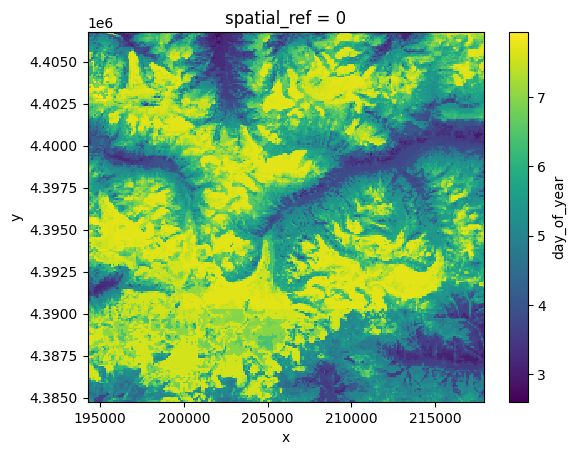

In [8]:
snow_melt.mean('year').pipe(lambda x: x/30).plot()

In [8]:
dem = data.get_dem_copernicus30(bbox_WSEN)

land_cover = data.get_esa_land_cover(dem)
albedo = data.get_modis_albedo_500m(dem)
emmissivity = data.get_aster_ged_emmis_elev(dem)

rock_glacier_mask = data.get_TPRoGI_rock_glaciers(
    target_dem=dem, dest_dir='./data/rock_glaciers')

glacier_mask = data.get_randolph_glacier_inventory(
    target_dem=dem, dest_dir='./data/glaciers',
)

mask = (glacier_mask.astype(int) + rock_glacier_mask.astype(int) * 2)

spatial_data = xr.merge([
    dem,
    land_cover,
    albedo,
    emmissivity,
    glacier_mask,
    rock_glacier_mask,
    mask.rename('mask'),
])

2025-04-08 11:25:48.200 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_dem_copernicus30:89 | Fetching COP DEM Global data from Planetary Computer (cop-dem-glo-30 @ 30m)
2025-04-08 11:25:49.103 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_esa_land_cover:175 | Fetching ESA World Cover (v2.0) data from Planetary Computer (esa-worldcover @ 30m)
2025-04-08 11:25:52.095 | INFO     | cryogrid_pytools.data.from_earth_engine.get_modis_albedo_500m:48 | Fetching MODIS albedo data from Earth Engine (MODIS/061/MCD43A3 @ 500m)
2025-04-08 11:25:55.033 | INFO     | cryogrid_pytools.data.from_earth_engine.get_aster_ged_100m_v3:102 | Fetching ASTER-GED emissivity data from Earth Engine (NASA/ASTER_GED/AG100_003 @ 100m)
2025-04-08 11:25:57.791 | WARNING  | cryogrid_pytools.data.shapefiles.get_TPRoGI_rock_glaciers:100 | No rock glaciers found in the bounding box.
2025-04-08 11:26:00.494 | INFO     | cryogrid_pytools.data.shapefiles.get_randolph_glacier_inventory:40 | RGI:

In [10]:
spatial_data

<xarray.Dataset> Size: 34MB
Dimensions:                         (x: 790, y: 732, band: 5)
Coordinates: (12/21)
  * x                               (x) float64 6kB 1.943e+05 ... 2.18e+05
  * y                               (y) float64 6kB 4.407e+06 ... 4.385e+06
    spatial_ref                     int64 8B 0
    created                         <U27 108B '2022-10-21T07:35:40.236136Z'
    grid:code                       <U21 84B 'ESAWORLDCOVER-N39E069'
    esa_worldcover:product_tile     <U7 28B 'N39E069'
    ...                              ...
    end_datetime                    <U20 80B '2021-12-31T23:59:59Z'
    proj:code                       <U9 36B 'EPSG:4326'
    platform                        <U50 200B 'sentinel-1a, sentinel-1b, sent...
    title                           <U18 72B 'Land Cover Classes'
  * band                            (band) int64 40B 10 11 12 13 14
    band_center                     (band) float64 40B 8.3 8.65 9.1 10.6 11.3
Data variables:
    cop_dem_glo_30                  (y, x) float64 5MB dask.array<chunksize=(730, 788), meta=np.ndarray>
    esa_world_cover                 (y, x) float64 5MB 60.0 100.0 ... 100.0
    modis_albedo_BSA_shortwave      (y, x) float64 5MB 0.118 0.118 ... 0.106
    aster_elevation                 (y, x) float32 2MB 3.641e+03 ... 3.777e+03
    aster_emissivity                (band, y, x) float32 12MB 0.97 ... 0.9605
    glaciers_RGI                    (y, x) bool 578kB False False ... False
    rock_glaciers_TPRoGI            (y, x) bool 578kB dask.array<chunksize=(730, 788), meta=np.ndarray>
    mask                            (y, x) int64 5MB dask.array<chunksize=(730, 788), meta=np.ndarray>
Attributes:
    smoothing_kernel:       box_kernel
    smoothing_kernel_size:  3
    smoothing_iterations:   2
    source:                 https://planetarycomputer.microsoft.com/api/stac/...
    bbox_request:           (71.44175183508192, 39.565609290405106, 71.708237...